# Dependencies

In [214]:
import numpy as np
import pandas as pd
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
import re
import ast
import sys
import cv2
import random
import json

!pip install num2words

## CSF
proj_data_dir = "../../proj_data/"
proj_model_dir = "../../proj_models/"



## Personal
# proj_data_dir = "D:/USB/data_gen_5/"


proj_code_dir = "../classes"
sys.path.append(proj_code_dir)


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [215]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, LSTM, TimeDistributed,Bidirectional, InputLayer,Attention,Dense,Dropout,Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report

!pip install datasets
from datasets import Dataset


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Prepare Data

In [216]:
data_mat = loadmat(os.path.join(proj_data_dir, "batches_landmark/all_split.mat"))

train_X = data_mat["train_data"]
train_Y = data_mat["train_labels"]

test_X = data_mat["test_data"]
test_Y = data_mat["test_labels"]

val_X = data_mat["val_data"]
val_Y = data_mat["val_labels"]

In [217]:
def show_data():
    print(f"test data length: {np.shape(train_X)}")
    print(f"Train labels length: {np.shape(train_Y)}")

    print(f"Test data length: {np.shape(test_X)}")
    print(f"Test labels length: {np.shape(test_Y)}")

    print(f"Validation data length: {np.shape(val_X)}")
    print(f"Validation labels length: {np.shape(val_Y)}")

In [218]:
show_data()

test data length: (3465, 29, 40, 3)
Train labels length: (3465,)
Test data length: (440, 29, 40, 3)
Test labels length: (440,)
Validation data length: (495, 29, 40, 3)
Validation labels length: (495,)


## Prune Data
Remove some frames of the data: some frames include other words

In [219]:
prune_begin = 4
prune_end = 4

In [220]:
def prune_data(data, before: int, after: int):
    new_data = []
    for batch in data:
        batch_length = len(batch)
        new_data.append(batch[before:(batch_length-after)])
    print(np.shape(new_data))
    return new_data

In [221]:
train_X = prune_data(data=train_X, before=prune_begin, after=prune_end)
test_X = prune_data(data=test_X, before=prune_begin, after=prune_end)
val_X = prune_data(data=val_X, before=prune_begin, after=prune_end)

(3465, 21, 40, 3)
(440, 21, 40, 3)
(495, 21, 40, 3)


In [222]:
show_data()

test data length: (3465, 21, 40, 3)
Train labels length: (3465,)
Test data length: (440, 21, 40, 3)
Test labels length: (440,)
Validation data length: (495, 21, 40, 3)
Validation labels length: (495,)


## Augment Data

In [223]:
import math

def rotate(x: float,y: float,z: float,theta: float,xo: float = 0.0,yo: float = 0.0):
    """
    Rotates an (x.y) about the origin specified by some theta
    """
    x_temp = x - xo
    y_temp = y - yo
    xr=math.cos(theta)*(x_temp)-math.sin(theta)*(y_temp)
    yr=math.sin(theta)*(x_temp)+math.cos(theta)*(y_temp)
    xr = xr + xo
    yr = yr + yo
    return [xr,yr,z]

def rotate_landmarks(landmarks, theta: float):
    new_landmarks = []
    for ldmk in landmarks:
        new_ldmk = rotate(x=ldmk[0],y=ldmk[1],z=ldmk[2],theta=theta, xo=0.5, yo=0.5)
        new_landmarks.append(new_ldmk)
    return new_landmarks

In [224]:
def augment_data(data, labels, rotate = False):
  new_data = []
  new_labels = []
  for frames, label in zip(data, labels):
    aug_vector = [[1,0,0] for _ in range(40)]
    frames_flip = [np.abs(frame - aug_vector) for frame in frames]
    ##Gets a random rotation. Makes sure this isn't too small of a rotation
    if(rotate):
      random_theta = 0.0
      while(-0.1 <= random_theta <= 0.1):
        random_theta = random.uniform(-math.pi/4, math.pi/4)
      frames_rotated = [rotate_landmarks(landmarks=frame, theta=random_theta) for frame in frames]
      frames_flip_rotated = [rotate_landmarks(landmarks=frame, theta=random_theta) for frame in frames_flip]

    new_data.append(np.array(frames))
    new_data.append(np.array(frames_flip))
    if(rotate):
      new_data.append(np.array(frames_rotated))
      new_data.append(np.array(frames_flip_rotated))

    if(rotate):
      new_labels += ([label] * 4)
    else:
      new_labels += ([label] * 2)
  return (new_data, new_labels)

In [225]:
train_X, train_Y = augment_data(data=train_X, labels=train_Y)
test_X, test_Y = augment_data(data=test_X, labels=test_Y)
val_X, val_Y = augment_data(data=val_X, labels=val_Y)

In [226]:
show_data()

test data length: (6930, 21, 40, 3)
Train labels length: (6930,)
Test data length: (880, 21, 40, 3)
Test labels length: (880,)
Validation data length: (990, 21, 40, 3)
Validation labels length: (990,)


## Data Example

In [227]:
def landmarks_to_img(landmarks):
  width = 200
  height = 200
  new_frame = np.zeros((width,height))
  for ldmk in landmarks:
      new_frame = cv2.circle(
          img=new_frame,
          center=(int(ldmk[0] * width), int(ldmk[1] * height)),
          radius=2,
          thickness=1,
          color=(255,255,255),
      )
  return new_frame

def show_frames(frames, landmark: bool):
  print(np.shape(frames))
  _, ax = plt.subplots(figsize=(18, 2))
  if(not landmark):
    row = frames[0]
    for x in range(1,len(frames)):
      row = np.concatenate((row, frames[x]), axis = 1)
    ax.imshow(row, cmap='gray', vmin=0, vmax=255)
  else:
    row = landmarks_to_img(frames[0])
    for x in range(1,len(frames)):
      row = np.concatenate((row, landmarks_to_img(frames[x])), axis = 1)
    ax.imshow(row, cmap='gray', vmin=0, vmax=255)


(21, 40, 3)
Class: FAMILY 


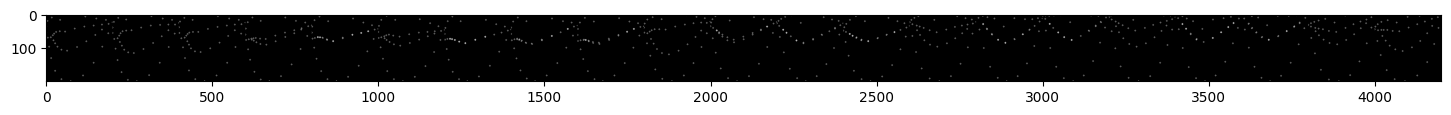

In [228]:
show_frames(frames=train_X[0],landmark=True)
print(f"Class: {train_Y[0]}")

(21, 40, 3)
Class: FAMILY 


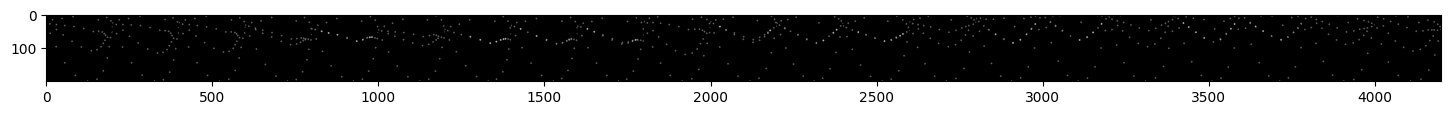

In [229]:
show_frames(frames=train_X[1],landmark=True)
print(f"Class: {train_Y[1]}")

## Encode Labels

In [230]:
number_of_frames = np.shape(train_X)[1]

In [236]:
word_set = np.unique(train_Y)
word_set.sort()
word_set = [x.strip() for x in word_set]
word_set = [word.ljust(number_of_frames, ' ') for word in word_set]

label_breakdown = [[x for x in word] for word in word_set]

letters = np.array([])
for label in label_breakdown:
    letters = np.concatenate((letters,label))
letters = np.unique(letters)

#One hot
# letter_encoder = keras.layers.StringLookup(
#     num_oov_indices=0, vocabulary=letters,output_mode="one_hot"
# )

#Numerical
letter_encodings = {letters[i]: i for i in range(len(letters))}
letter_encodings[" "] = len(letters) #Encode padding as the last index in the array due to how CTC handles blank space

num_encodings = {letter_encodings[key]:key for key in list(letter_encodings.keys())}

word_encodings = {word_set[i]: [letter_encodings[letter] for letter in word_set[i]] for i in range(len(word_set))}

print(f"Letters to numbers: {letter_encodings}")
print(f"Numbers to letters: {num_encodings}")
print(f"Word to numbers: {word_encodings}")

num_letters = len(letters)

Letters to numbers: {' ': 16, 'A': 1, 'B': 2, 'C': 3, 'E': 4, 'F': 5, 'H': 6, 'I': 7, 'L': 8, 'M': 9, 'N': 10, 'O': 11, 'T': 12, 'U': 13, 'V': 14, 'Y': 15}
Numbers to letters: {16: ' ', 1: 'A', 2: 'B', 3: 'C', 4: 'E', 5: 'F', 6: 'H', 7: 'I', 8: 'L', 9: 'M', 10: 'N', 11: 'O', 12: 'T', 13: 'U', 14: 'V', 15: 'Y'}
Word to numbers: {'ABOUT                ': [1, 2, 11, 13, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16], 'BELIEVE              ': [2, 4, 8, 7, 4, 14, 4, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16], 'CHANCE               ': [3, 6, 1, 10, 3, 4, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16], 'FAMILY               ': [5, 1, 9, 7, 8, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]}


In [237]:
#Numeric
def encode_letter(letter:str):
    return letter_encodings[letter]

def encode_word(word:str, pad=False):
    vid_length = len(train_X[0])
    temp = word_encodings[word]

    if(pad):
        while(len(temp) < vid_length):
            temp.append(0.0)
    return np.array(temp)

def decode_word(encoded_word):
    word = ""
    for num in encoded_word:
        word += num_encodings[num]
    return word

def encode_labels(labels):
    return np.array([encode_word(label.ljust(number_of_frames, ' ')) for label in labels])

#One hot
# def encode_letter(letter:str):
#     return letter_encoder(letter).numpy()

# def encode_word(word:str):
#     word = word
#     ret_word = []
#     for letter in word:
#         ret_word.append(letter_encoder(letter).numpy())
#     return ret_word

# def decode_word(encoded_word):
#     word = ""
#     for one_hot in encoded_word:
#         word += letters[np.argmax(one_hot)]
#     return word

# def encode_labels(labels):
#     return np.array([encode_word(label) for label in labels])

In [238]:
train_Y = encode_labels(labels=train_Y)
test_Y = encode_labels(labels=test_Y)
val_Y = encode_labels(labels=val_Y)

print(train_Y)
print(np.shape(train_Y))

[[ 5  1  9 ... 16 16 16]
 [ 5  1  9 ... 16 16 16]
 [ 3  6  1 ... 16 16 16]
 ...
 [ 5  1  9 ... 16 16 16]
 [ 3  6  1 ... 16 16 16]
 [ 3  6  1 ... 16 16 16]]
(6930, 21)


# Model Training

## Learning Rate Scheduler

In [239]:
initial_lr = 0.001

# def scheduler(epoch, lr):
#     if(epoch < 30):
#         return lr
#     else:
#         return lr * tf.math.exp(-0.01)
# schedule_callback = LearningRateScheduler(scheduler)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(proj_model_dir, "best_run.hdf5"),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr,decay_steps=275,decay_rate=0.975,staircase=True)

## Model Architecture

Model is video based & word based. It uses feature vectors extracted for each frame.

In [240]:
print(np.shape(train_X))
print(np.shape(train_Y))

print(np.shape(val_X))
print(np.shape(val_Y))

(6930, 21, 40, 3)
(6930, 21)
(990, 21, 40, 3)
(990, 21)


In [241]:
batch_size: int = 32

train_ds = tf.data.Dataset.from_tensor_slices(
  (train_X, train_Y)
)
train_ds = train_ds.padded_batch(batch_size, padded_shapes=(np.shape(train_X[0]),np.shape(train_Y[0])))
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(
  (test_X, test_Y)
)
test_ds = test_ds.padded_batch(batch_size, padded_shapes=(np.shape(test_X[0]),np.shape(test_Y[0])))
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
  (val_X, val_Y)
)
val_ds = test_ds.padded_batch(batch_size, padded_shapes=((None,) + np.shape(val_X[0]),(None,) + np.shape(val_Y[0])))
val_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [242]:
### Vanilla Bi-LSTM
model = Sequential([
   layers.InputLayer(input_shape= (None, 40,3)),
   layers.TimeDistributed(Flatten()),
   layers.Bidirectional(LSTM(128,activation='relu', return_sequences=True)),
   layers.Bidirectional(LSTM(128,activation='relu', return_sequences=True)),
   layers.Bidirectional(LSTM(128,activation='relu', return_sequences=True)),
   layers.Dense(64,activation='relu'),
   layers.Dense(32,activation='relu'),
   layers.Dense(num_letters + 1,activation='softmax')
])

#Added attention layer
# input_layer = Input(shape= np.shape(train_X[0]))
# flatten_layer = TimeDistributed(Flatten())(input_layer)
# attention_layer = Attention(use_scale=True)([flatten_layer,flatten_layer])
# bilstm_layer1 = Bidirectional(LSTM(128,activation='relu', return_sequences=True))(attention_layer)
# bilstm_layer2 = Bidirectional(LSTM(128,activation='relu', return_sequences=True))(bilstm_layer1)
# bilstm_layer3 = Bidirectional(LSTM(128,activation='relu', return_sequences=False))(bilstm_layer2)
# dense_layer1 = Dense(64,activation='relu')(bilstm_layer3)
# dropout_layer1 = Dropout(0.2)(dense_layer1)
# dense_layer2 = Dense(64,activation='relu')(dropout_layer1)
# dropout_layer2 = Dropout(0.2)(dense_layer2)
# dense_layer3 = Dense(64,activation='relu')(dropout_layer2)
# dropout_layer3 = Dropout(0.2)(dense_layer3)
# output_layer = Dense(num_letters,activation='softmax')(dropout_layer3)
# model = Model(inputs=input_layer, outputs=output_layer)

In [243]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value

    batch_len = tf.cast(tf.shape(y_pred)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [244]:
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss=CTCLoss,
              metrics=['accuracy'])

In [245]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, None, 120)         0         
 stributed)                                                      
                                                                 
 bidirectional_12 (Bidirect  (None, None, 256)         254976    
 ional)                                                          
                                                                 
 bidirectional_13 (Bidirect  (None, None, 256)         394240    
 ional)                                                          
                                                                 
 bidirectional_14 (Bidirect  (None, None, 256)         394240    
 ional)                                                          
                                                                 
 dense_12 (Dense)            (None, None, 64)         

## Example Before Training

In [246]:
test_sample = train_X[0]
test_sample = tf.expand_dims(test_sample, 0)

test_label = train_Y[0]

print(f"Model input shape: {model.input_shape}")
print(f"Model output shape: {model.output_shape}")
test_out = model.predict(test_sample)
predicted = tf.argmax(test_out,axis=2)

print(f"Predicted: {test_out}")
print(f"True: {test_label}")

print(f"Predicted shape: {np.shape(test_out)}")
print(f"True shape: {np.shape(test_label)}")

print(f"Translated Predicted: {decode_word(predicted.numpy()[0])}")
print(f"Translated True: {decode_word(test_label)}")

Model input shape: (None, None, 40, 3)
Model output shape: (None, None, 17)
1/1 [==============================] - 1s 1s/step
Predicted: [[[0.059919   0.05791303 0.05852776 0.05820153 0.05852146 0.0586661
   0.05950758 0.05703598 0.06070962 0.05957311 0.0595835  0.05762992
   0.05741607 0.05935863 0.05855318 0.05981034 0.05907324]
  [0.05973083 0.0580931  0.05875749 0.05775347 0.05835762 0.05821485
   0.05975838 0.05701226 0.06072158 0.05971663 0.05954936 0.05790059
   0.05750358 0.05929398 0.05842002 0.05969166 0.05952456]
  [0.05954871 0.05813366 0.05889234 0.05738734 0.05830694 0.05793029
   0.05997892 0.05703457 0.06069703 0.05983683 0.05952663 0.05815679
   0.0574892  0.05924265 0.05844468 0.05955277 0.05984066]
  [0.05942667 0.05813772 0.05905646 0.05709195 0.0583156  0.05757446
   0.06011064 0.05710137 0.06066612 0.05999515 0.05955831 0.05841774
   0.05739529 0.05906807 0.05857907 0.05948095 0.06002441]
  [0.05932325 0.05814006 0.05926822 0.05683516 0.05839071 0.05725551
   0.06

KeyError: 0

## Training

In [247]:
epochs = 200
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  callbacks=[model_checkpoint_callback]
)

Epoch 1/200
199/217 [==========================>...] - ETA: 1s - loss: 14.4915 - accuracy: 0.4884

KeyboardInterrupt: 

## Save Model

In [ ]:
# model.save(os.path.join(proj_model_dir, "newest_model.keras"))

# model.save_weights(os.path.join(proj_model_dir, "newest_model.hdf5"))
model_architecture = model.to_json()
with open(os.path.join(proj_model_dir, "best_run.json"), "w") as f:
  f.write(json.dumps(model_architecture, indent=4))

# Metrics

## Display Metrics

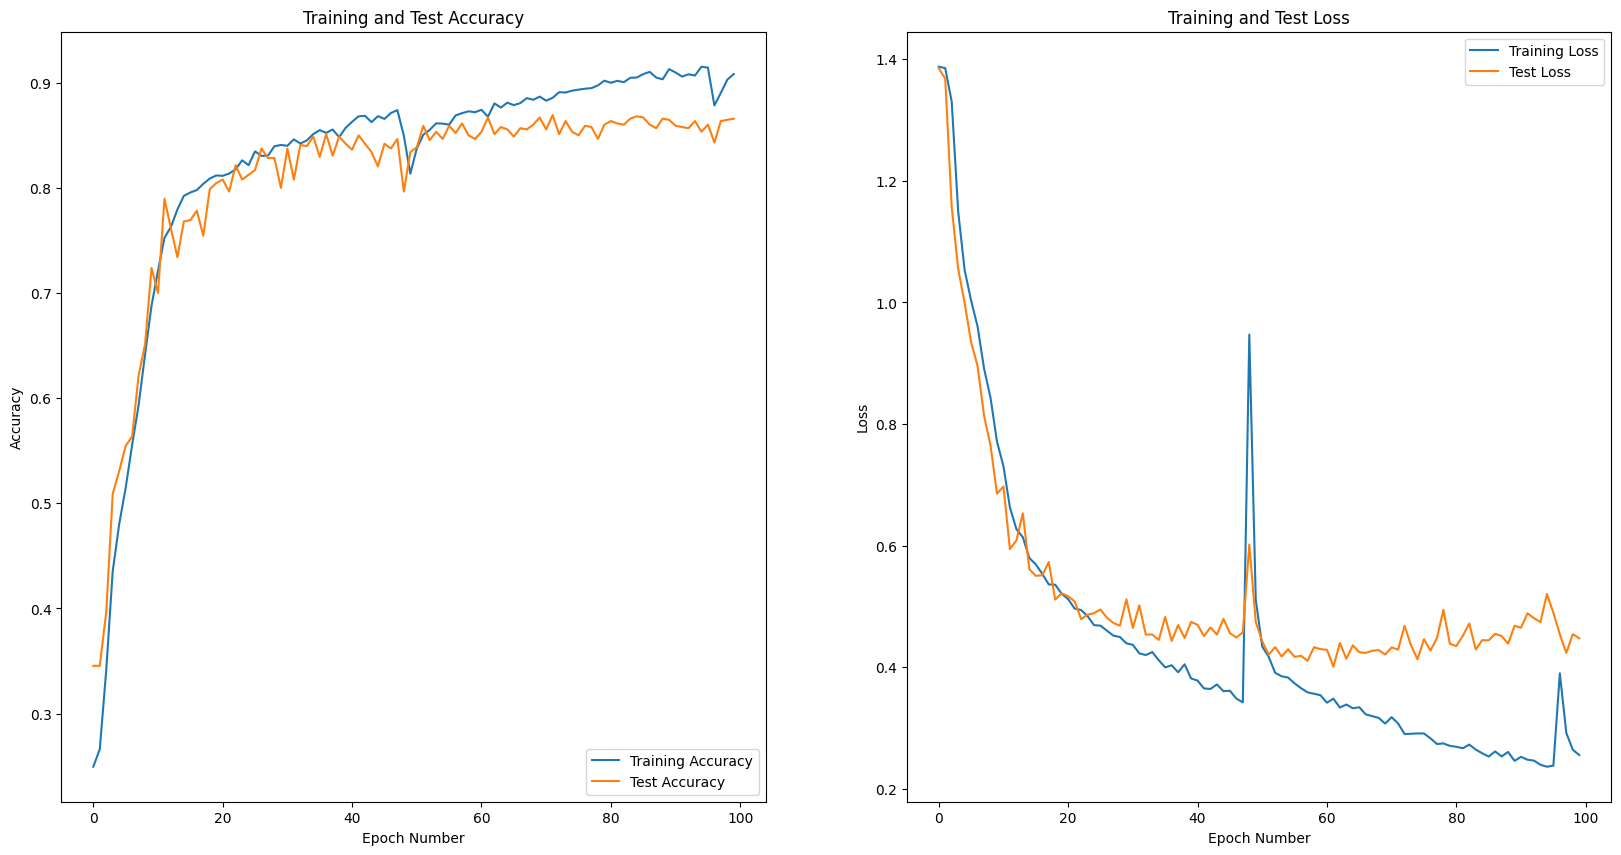

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

plt.savefig(os.path.join(proj_model_dir, "newest_model_metrics.pdf"))

plt.show()

In [ ]:
# best_model = keras.models.model_from_json(model_architecture)
# best_model.load_weights(os.path.join(proj_model_dir, "best_run.hdf5"))
# best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# val_result = best_model.evaluate(val_ds)

# loss = val_result[0]
# accuracy = val_result[1]
# print("Validation Loss:", loss)
# print("Validation Accuracy:", accuracy)

28/28 [==============================] - 4s 36ms/step - loss: 0.4289 - accuracy: 0.8693
Validation Loss: 0.42891430854797363
Validation Accuracy: 0.8693181872367859


In [ ]:
# y_pred = best_model.predict(np.array(val_X),batch_size=len(val_X))
# y_pred_labels = np.argmax(y_pred, axis=1)
# y_true_labels = np.argmax(val_Y, axis=1)

# class_report = classification_report(y_true_labels, y_pred_labels)
# print(class_report)

1/1 [==============================] - 3s 3s/step
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       222
           1       0.84      0.74      0.79       246
           2       0.90      0.93      0.92       264
           3       0.89      0.89      0.89       258

    accuracy                           0.84       990
   macro avg       0.84      0.84      0.84       990
weighted avg       0.84      0.84      0.84       990

